# Wasserstein GAN

The Wasserstein GAN [(paper here)](https://arxiv.org/abs/1701.07875) is a improve GAN model that improves learning stability and helps get rid of problems like mode collapse, which we experienced with our first GAN model.

In [42]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets as dset
from torch.autograd import Variable

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

In [23]:
# Parameters
dataroot = "./data"

n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5 # adam decay of gradient
b2 = 0.999 # adam decay of gradient
latent_dim = 100
img_size = 64
channels = 3
n_critic = 5 # number of training steps for discriminator per iteration
clip_value = 0.01 # lower and upper clip value for disc. weights
sample_interval = 400 # interval between image samples

img_shape = (channels, img_size, img_size)

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu == 1) else "cpu")
print("Will run on device", device)

Will run on device cuda:0


In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [18]:
# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device);

In [24]:
# Configure data loader
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [29]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if device.type == 'cuda' else torch.FloatTensor

In [30]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [40]:
# ----------
#  Training
# ----------
img_list = []
batches_done = 0
fixed_noise = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
iters = 0

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            batches_done += n_critic
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                img_list.append(make_grid(fake, padding=2, normalize=True))
                
            iters += 1

[Epoch 0/200] [Batch 0/36] [D loss: -33.263962] [G loss: -5.324268]
[Epoch 0/200] [Batch 5/36] [D loss: -41.841679] [G loss: -8.157930]
[Epoch 0/200] [Batch 10/36] [D loss: -46.243435] [G loss: -9.702499]
[Epoch 0/200] [Batch 15/36] [D loss: -52.597511] [G loss: -11.605581]
[Epoch 0/200] [Batch 20/36] [D loss: -58.472527] [G loss: -13.273661]
[Epoch 0/200] [Batch 25/36] [D loss: -59.845203] [G loss: -14.575729]
[Epoch 0/200] [Batch 30/36] [D loss: -66.108376] [G loss: -16.528761]
[Epoch 0/200] [Batch 35/36] [D loss: -61.555698] [G loss: -17.660397]
[Epoch 1/200] [Batch 0/36] [D loss: -54.504986] [G loss: -18.656822]
[Epoch 1/200] [Batch 5/36] [D loss: -73.130508] [G loss: -18.530109]
[Epoch 1/200] [Batch 10/36] [D loss: -74.036942] [G loss: -15.811871]
[Epoch 1/200] [Batch 15/36] [D loss: -58.386189] [G loss: -17.549871]
[Epoch 1/200] [Batch 20/36] [D loss: -50.670559] [G loss: -17.208595]
[Epoch 1/200] [Batch 25/36] [D loss: -61.939568] [G loss: -18.003843]
[Epoch 1/200] [Batch 30/36]

[Epoch 14/200] [Batch 35/36] [D loss: -11.769975] [G loss: -1.111377]
[Epoch 15/200] [Batch 0/36] [D loss: -14.346987] [G loss: -0.665206]
[Epoch 15/200] [Batch 5/36] [D loss: -19.424961] [G loss: 12.832047]
[Epoch 15/200] [Batch 10/36] [D loss: -15.961504] [G loss: -3.774865]
[Epoch 15/200] [Batch 15/36] [D loss: -18.832901] [G loss: 6.513965]
[Epoch 15/200] [Batch 20/36] [D loss: -15.802742] [G loss: -4.720424]
[Epoch 15/200] [Batch 25/36] [D loss: -12.218815] [G loss: 6.554599]
[Epoch 15/200] [Batch 30/36] [D loss: -18.959820] [G loss: 10.124861]
[Epoch 15/200] [Batch 35/36] [D loss: -14.563746] [G loss: -0.070635]
[Epoch 16/200] [Batch 0/36] [D loss: -14.601989] [G loss: -2.040209]
[Epoch 16/200] [Batch 5/36] [D loss: -10.179442] [G loss: -5.469570]
[Epoch 16/200] [Batch 10/36] [D loss: -13.855793] [G loss: 0.866850]
[Epoch 16/200] [Batch 15/36] [D loss: -14.776649] [G loss: 5.358055]
[Epoch 16/200] [Batch 20/36] [D loss: -14.976215] [G loss: -5.164242]
[Epoch 16/200] [Batch 25/36]

[Epoch 29/200] [Batch 30/36] [D loss: -11.702094] [G loss: -5.763339]
[Epoch 29/200] [Batch 35/36] [D loss: -12.934700] [G loss: 5.714405]
[Epoch 30/200] [Batch 0/36] [D loss: -13.614094] [G loss: 0.086982]
[Epoch 30/200] [Batch 5/36] [D loss: -11.939410] [G loss: 3.320650]
[Epoch 30/200] [Batch 10/36] [D loss: -14.328790] [G loss: 12.923399]
[Epoch 30/200] [Batch 15/36] [D loss: -14.504992] [G loss: 6.514382]
[Epoch 30/200] [Batch 20/36] [D loss: -12.476823] [G loss: 14.923185]
[Epoch 30/200] [Batch 25/36] [D loss: -14.243954] [G loss: 17.817154]
[Epoch 30/200] [Batch 30/36] [D loss: -14.029509] [G loss: 21.403919]
[Epoch 30/200] [Batch 35/36] [D loss: -14.305502] [G loss: 8.744791]
[Epoch 31/200] [Batch 0/36] [D loss: -13.832440] [G loss: 15.396940]
[Epoch 31/200] [Batch 5/36] [D loss: -13.348848] [G loss: -1.882024]
[Epoch 31/200] [Batch 10/36] [D loss: -10.232676] [G loss: -7.490442]
[Epoch 31/200] [Batch 15/36] [D loss: -12.588663] [G loss: -5.273702]
[Epoch 31/200] [Batch 20/36] 

[Epoch 44/200] [Batch 25/36] [D loss: -11.977642] [G loss: 1.034992]
[Epoch 44/200] [Batch 30/36] [D loss: -12.115652] [G loss: 5.051252]
[Epoch 44/200] [Batch 35/36] [D loss: -11.074326] [G loss: 6.598546]
[Epoch 45/200] [Batch 0/36] [D loss: -10.966007] [G loss: 7.250250]
[Epoch 45/200] [Batch 5/36] [D loss: -12.604847] [G loss: 3.594789]
[Epoch 45/200] [Batch 10/36] [D loss: -11.638635] [G loss: -9.664823]
[Epoch 45/200] [Batch 15/36] [D loss: -8.933815] [G loss: -4.354339]
[Epoch 45/200] [Batch 20/36] [D loss: -11.191021] [G loss: 10.306829]
[Epoch 45/200] [Batch 25/36] [D loss: -9.240597] [G loss: 4.977986]
[Epoch 45/200] [Batch 30/36] [D loss: -10.698700] [G loss: 9.770893]
[Epoch 45/200] [Batch 35/36] [D loss: -10.543394] [G loss: 0.762186]
[Epoch 46/200] [Batch 0/36] [D loss: -10.474736] [G loss: -2.169621]
[Epoch 46/200] [Batch 5/36] [D loss: -8.355865] [G loss: -0.983981]
[Epoch 46/200] [Batch 10/36] [D loss: -10.665751] [G loss: -2.848690]
[Epoch 46/200] [Batch 15/36] [D los

[Epoch 59/200] [Batch 20/36] [D loss: -11.445595] [G loss: -8.185902]
[Epoch 59/200] [Batch 25/36] [D loss: -9.824833] [G loss: 0.768178]
[Epoch 59/200] [Batch 30/36] [D loss: -15.436906] [G loss: -14.971493]
[Epoch 59/200] [Batch 35/36] [D loss: -10.016564] [G loss: -11.789380]
[Epoch 60/200] [Batch 0/36] [D loss: -9.190769] [G loss: -9.134312]
[Epoch 60/200] [Batch 5/36] [D loss: -5.829889] [G loss: -7.844544]
[Epoch 60/200] [Batch 10/36] [D loss: -8.844667] [G loss: 1.012771]
[Epoch 60/200] [Batch 15/36] [D loss: -9.755165] [G loss: 13.036815]
[Epoch 60/200] [Batch 20/36] [D loss: -14.253138] [G loss: 14.042538]
[Epoch 60/200] [Batch 25/36] [D loss: -9.210260] [G loss: 12.023641]
[Epoch 60/200] [Batch 30/36] [D loss: -10.531894] [G loss: 16.972282]
[Epoch 60/200] [Batch 35/36] [D loss: -9.019403] [G loss: 22.522692]
[Epoch 61/200] [Batch 0/36] [D loss: -7.274475] [G loss: 11.684357]
[Epoch 61/200] [Batch 5/36] [D loss: -8.168512] [G loss: 2.735061]
[Epoch 61/200] [Batch 10/36] [D lo

[Epoch 74/200] [Batch 20/36] [D loss: -9.551434] [G loss: 11.602022]
[Epoch 74/200] [Batch 25/36] [D loss: -11.272665] [G loss: 24.802269]
[Epoch 74/200] [Batch 30/36] [D loss: -10.212807] [G loss: 14.105097]
[Epoch 74/200] [Batch 35/36] [D loss: -7.642491] [G loss: 18.548326]
[Epoch 75/200] [Batch 0/36] [D loss: -7.154778] [G loss: 16.686668]
[Epoch 75/200] [Batch 5/36] [D loss: -8.025274] [G loss: 15.622107]
[Epoch 75/200] [Batch 10/36] [D loss: -9.317755] [G loss: 0.537840]
[Epoch 75/200] [Batch 15/36] [D loss: -10.875732] [G loss: -1.534040]
[Epoch 75/200] [Batch 20/36] [D loss: -8.190849] [G loss: -9.342178]
[Epoch 75/200] [Batch 25/36] [D loss: -10.037906] [G loss: -10.409613]
[Epoch 75/200] [Batch 30/36] [D loss: -8.719007] [G loss: -8.195270]
[Epoch 75/200] [Batch 35/36] [D loss: -7.990310] [G loss: -5.009195]
[Epoch 76/200] [Batch 0/36] [D loss: -7.895112] [G loss: -5.365493]
[Epoch 76/200] [Batch 5/36] [D loss: -8.465092] [G loss: -1.779024]
[Epoch 76/200] [Batch 10/36] [D lo

[Epoch 89/200] [Batch 20/36] [D loss: -10.269398] [G loss: -2.873002]
[Epoch 89/200] [Batch 25/36] [D loss: -10.290138] [G loss: -7.139117]
[Epoch 89/200] [Batch 30/36] [D loss: -9.394615] [G loss: -4.693580]
[Epoch 89/200] [Batch 35/36] [D loss: -10.389020] [G loss: -6.058729]
[Epoch 90/200] [Batch 0/36] [D loss: -10.697309] [G loss: -10.787323]
[Epoch 90/200] [Batch 5/36] [D loss: -10.818193] [G loss: 1.324512]
[Epoch 90/200] [Batch 10/36] [D loss: -8.453071] [G loss: -3.775119]
[Epoch 90/200] [Batch 15/36] [D loss: -7.477724] [G loss: -1.558478]
[Epoch 90/200] [Batch 20/36] [D loss: -11.723159] [G loss: -6.372114]
[Epoch 90/200] [Batch 25/36] [D loss: -10.762362] [G loss: 6.422299]
[Epoch 90/200] [Batch 30/36] [D loss: -10.095640] [G loss: 5.796029]
[Epoch 90/200] [Batch 35/36] [D loss: -9.002788] [G loss: 19.107010]
[Epoch 91/200] [Batch 0/36] [D loss: -10.021441] [G loss: 18.641619]
[Epoch 91/200] [Batch 5/36] [D loss: -10.704014] [G loss: 17.433168]
[Epoch 91/200] [Batch 10/36] [

[Epoch 104/200] [Batch 15/36] [D loss: -8.152271] [G loss: 7.500813]
[Epoch 104/200] [Batch 20/36] [D loss: -10.841235] [G loss: 9.995743]
[Epoch 104/200] [Batch 25/36] [D loss: -11.950443] [G loss: 10.670457]
[Epoch 104/200] [Batch 30/36] [D loss: -8.020404] [G loss: 7.455408]
[Epoch 104/200] [Batch 35/36] [D loss: -7.451128] [G loss: 5.662680]
[Epoch 105/200] [Batch 0/36] [D loss: -10.714690] [G loss: 4.340379]
[Epoch 105/200] [Batch 5/36] [D loss: -7.966898] [G loss: -9.146755]
[Epoch 105/200] [Batch 10/36] [D loss: -7.604378] [G loss: 8.809365]
[Epoch 105/200] [Batch 15/36] [D loss: -10.808802] [G loss: -5.049029]
[Epoch 105/200] [Batch 20/36] [D loss: -10.311052] [G loss: -4.479532]
[Epoch 105/200] [Batch 25/36] [D loss: -9.601966] [G loss: 1.916032]
[Epoch 105/200] [Batch 30/36] [D loss: -6.107089] [G loss: -1.588189]
[Epoch 105/200] [Batch 35/36] [D loss: -9.521432] [G loss: -16.877064]
[Epoch 106/200] [Batch 0/36] [D loss: -11.567838] [G loss: -17.204182]
[Epoch 106/200] [Batch

[Epoch 119/200] [Batch 5/36] [D loss: -6.318472] [G loss: 13.314774]
[Epoch 119/200] [Batch 10/36] [D loss: -4.829436] [G loss: 2.364096]
[Epoch 119/200] [Batch 15/36] [D loss: -10.363276] [G loss: 0.975208]
[Epoch 119/200] [Batch 20/36] [D loss: -7.455892] [G loss: 5.131014]
[Epoch 119/200] [Batch 25/36] [D loss: -9.424181] [G loss: 0.200562]
[Epoch 119/200] [Batch 30/36] [D loss: -11.755873] [G loss: 2.810859]
[Epoch 119/200] [Batch 35/36] [D loss: -14.579101] [G loss: -9.068100]
[Epoch 120/200] [Batch 0/36] [D loss: -8.623587] [G loss: -14.438154]
[Epoch 120/200] [Batch 5/36] [D loss: -10.154537] [G loss: -13.892906]
[Epoch 120/200] [Batch 10/36] [D loss: -11.434097] [G loss: -7.403723]
[Epoch 120/200] [Batch 15/36] [D loss: -10.255688] [G loss: -13.115261]
[Epoch 120/200] [Batch 20/36] [D loss: -10.317075] [G loss: -1.986333]
[Epoch 120/200] [Batch 25/36] [D loss: -7.559333] [G loss: 1.231746]
[Epoch 120/200] [Batch 30/36] [D loss: -6.497017] [G loss: 14.344675]
[Epoch 120/200] [Ba

[Epoch 133/200] [Batch 35/36] [D loss: -8.387272] [G loss: -9.539791]
[Epoch 134/200] [Batch 0/36] [D loss: -6.863308] [G loss: -7.659140]
[Epoch 134/200] [Batch 5/36] [D loss: -9.734462] [G loss: -0.221173]
[Epoch 134/200] [Batch 10/36] [D loss: -8.858900] [G loss: -2.080039]
[Epoch 134/200] [Batch 15/36] [D loss: -7.422639] [G loss: 0.376717]
[Epoch 134/200] [Batch 20/36] [D loss: -10.304120] [G loss: 0.528186]
[Epoch 134/200] [Batch 25/36] [D loss: -5.413054] [G loss: -2.194232]
[Epoch 134/200] [Batch 30/36] [D loss: -7.972380] [G loss: -4.591817]
[Epoch 134/200] [Batch 35/36] [D loss: -6.653009] [G loss: 9.188995]
[Epoch 135/200] [Batch 0/36] [D loss: -7.845278] [G loss: 8.539180]
[Epoch 135/200] [Batch 5/36] [D loss: -9.122153] [G loss: 7.754312]
[Epoch 135/200] [Batch 10/36] [D loss: -10.194646] [G loss: 7.349828]
[Epoch 135/200] [Batch 15/36] [D loss: -8.519118] [G loss: 4.443357]
[Epoch 135/200] [Batch 20/36] [D loss: -9.489866] [G loss: 2.921402]
[Epoch 135/200] [Batch 25/36] 

[Epoch 148/200] [Batch 25/36] [D loss: -14.835496] [G loss: 1.030459]
[Epoch 148/200] [Batch 30/36] [D loss: -10.355060] [G loss: 1.898452]
[Epoch 148/200] [Batch 35/36] [D loss: -7.154417] [G loss: 11.066132]
[Epoch 149/200] [Batch 0/36] [D loss: -9.681710] [G loss: 12.064600]
[Epoch 149/200] [Batch 5/36] [D loss: -11.846563] [G loss: 0.474407]
[Epoch 149/200] [Batch 10/36] [D loss: -10.800919] [G loss: -10.548473]
[Epoch 149/200] [Batch 15/36] [D loss: -8.219299] [G loss: -2.083049]
[Epoch 149/200] [Batch 20/36] [D loss: -10.010632] [G loss: 0.456206]
[Epoch 149/200] [Batch 25/36] [D loss: -9.787356] [G loss: -2.072499]
[Epoch 149/200] [Batch 30/36] [D loss: -11.158650] [G loss: -1.839689]
[Epoch 149/200] [Batch 35/36] [D loss: -7.028326] [G loss: 3.640583]
[Epoch 150/200] [Batch 0/36] [D loss: -7.418459] [G loss: 4.399578]
[Epoch 150/200] [Batch 5/36] [D loss: -11.512693] [G loss: 0.390250]
[Epoch 150/200] [Batch 10/36] [D loss: -8.840054] [G loss: 13.001577]
[Epoch 150/200] [Batch 

[Epoch 163/200] [Batch 15/36] [D loss: -8.596427] [G loss: -5.017689]
[Epoch 163/200] [Batch 20/36] [D loss: -9.356254] [G loss: -0.153312]
[Epoch 163/200] [Batch 25/36] [D loss: -9.000314] [G loss: 4.831964]
[Epoch 163/200] [Batch 30/36] [D loss: -10.370062] [G loss: 4.005551]
[Epoch 163/200] [Batch 35/36] [D loss: -11.631065] [G loss: 6.942294]
[Epoch 164/200] [Batch 0/36] [D loss: -9.152000] [G loss: 5.211833]
[Epoch 164/200] [Batch 5/36] [D loss: -12.899273] [G loss: 3.935405]
[Epoch 164/200] [Batch 10/36] [D loss: -12.275743] [G loss: -8.495687]
[Epoch 164/200] [Batch 15/36] [D loss: -9.967767] [G loss: -1.331851]
[Epoch 164/200] [Batch 20/36] [D loss: -12.427057] [G loss: 14.899557]
[Epoch 164/200] [Batch 25/36] [D loss: -9.160149] [G loss: 15.092732]
[Epoch 164/200] [Batch 30/36] [D loss: -11.514247] [G loss: 4.049617]
[Epoch 164/200] [Batch 35/36] [D loss: -12.311577] [G loss: -1.937396]
[Epoch 165/200] [Batch 0/36] [D loss: -5.400846] [G loss: -5.394397]
[Epoch 165/200] [Batch

[Epoch 178/200] [Batch 5/36] [D loss: -10.776031] [G loss: 11.567766]
[Epoch 178/200] [Batch 10/36] [D loss: -7.640283] [G loss: 6.581469]
[Epoch 178/200] [Batch 15/36] [D loss: -8.771042] [G loss: 5.012366]
[Epoch 178/200] [Batch 20/36] [D loss: -10.133579] [G loss: 0.673565]
[Epoch 178/200] [Batch 25/36] [D loss: -9.105482] [G loss: 6.815892]
[Epoch 178/200] [Batch 30/36] [D loss: -6.690596] [G loss: -5.564435]
[Epoch 178/200] [Batch 35/36] [D loss: -12.712524] [G loss: -1.940388]
[Epoch 179/200] [Batch 0/36] [D loss: -9.233476] [G loss: -9.477877]
[Epoch 179/200] [Batch 5/36] [D loss: -7.517121] [G loss: -3.877303]
[Epoch 179/200] [Batch 10/36] [D loss: -8.832100] [G loss: -5.464794]
[Epoch 179/200] [Batch 15/36] [D loss: -11.340383] [G loss: 7.287591]
[Epoch 179/200] [Batch 20/36] [D loss: -13.903355] [G loss: 2.658890]
[Epoch 179/200] [Batch 25/36] [D loss: -6.187214] [G loss: 1.385633]
[Epoch 179/200] [Batch 30/36] [D loss: -6.566689] [G loss: 13.041491]
[Epoch 179/200] [Batch 35

[Epoch 192/200] [Batch 35/36] [D loss: -8.255342] [G loss: 7.737793]
[Epoch 193/200] [Batch 0/36] [D loss: -7.408192] [G loss: 2.600827]
[Epoch 193/200] [Batch 5/36] [D loss: -10.558763] [G loss: -0.303648]
[Epoch 193/200] [Batch 10/36] [D loss: -8.416614] [G loss: -0.334413]
[Epoch 193/200] [Batch 15/36] [D loss: -9.746828] [G loss: -7.042879]
[Epoch 193/200] [Batch 20/36] [D loss: -8.769300] [G loss: -1.475170]
[Epoch 193/200] [Batch 25/36] [D loss: -9.993841] [G loss: 5.840604]
[Epoch 193/200] [Batch 30/36] [D loss: -10.447404] [G loss: -0.716506]
[Epoch 193/200] [Batch 35/36] [D loss: -12.300236] [G loss: -1.829845]
[Epoch 194/200] [Batch 0/36] [D loss: -9.378216] [G loss: -2.737556]
[Epoch 194/200] [Batch 5/36] [D loss: -9.649199] [G loss: 3.308156]
[Epoch 194/200] [Batch 10/36] [D loss: -9.169146] [G loss: 6.476273]
[Epoch 194/200] [Batch 15/36] [D loss: -9.103978] [G loss: 4.651872]
[Epoch 194/200] [Batch 20/36] [D loss: -8.336837] [G loss: -4.792970]
[Epoch 194/200] [Batch 25/3

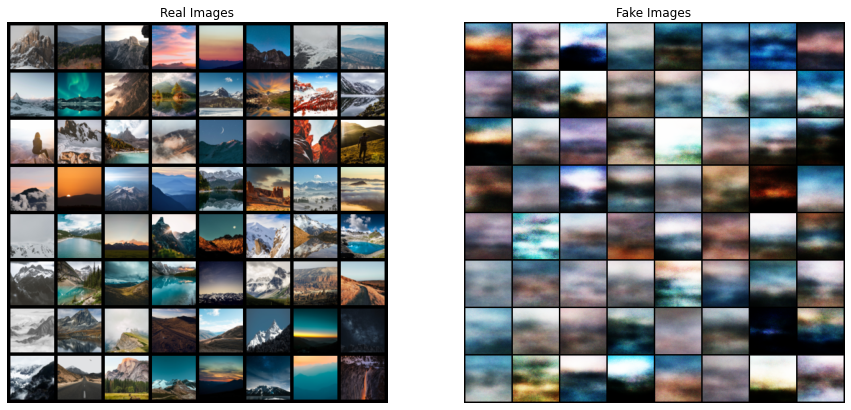

In [44]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()